In [1]:
import os
import warnings
import datetime
from collections import Counter

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler, label_binarize
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score, confusion_matrix, classification_report,
    roc_curve, auc, roc_auc_score,
    precision_score, recall_score, f1_score
)

from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.combine import SMOTETomek

from sklearn.decomposition import PCA

from catboost import CatBoostClassifier

from tensorflow import keras
from keras import layers
from keras.losses import BinaryFocalCrossentropy
from keras.metrics import AUC, Precision, Recall

from sklearn.utils.class_weight import compute_class_weight
import keras
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    confusion_matrix, classification_report, accuracy_score,
    f1_score, roc_auc_score, precision_score, recall_score
)
from keras import Sequential
from keras.layers import Dense, Dropout, BatchNormalization
from keras.optimizers import Adam
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, roc_curve, auc
from sklearn.preprocessing import label_binarize
from catboost import CatBoostClassifier
from imblearn.combine import SMOTETomek
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

warnings.simplefilter(action='ignore', category=pd.errors.SettingWithCopyWarning)


In [13]:
data = pd.read_excel("data_pipeline_output_with_testdata.xlsx")
data.drop(columns=['Unnamed: 0'], inplace=True)
data = data.sort_values(by="Date")

cols = ['Status', 'Provider', 'Rocket', 'Mission', 'temperature_2m',
    'relative_humidity_2m', 'wind_speed_10m', 'pressure_msl',
    'Hr', 'Mins', 'Year of launch', 'Decade', 'AmPm',
    'Launch Pad Name', 'Launch Pad Location', 'Launch Country', 'Season']

encoded_data = data[cols].copy()


label_encoders = {}

categorical_cols = encoded_data.select_dtypes(include=['object']).columns.tolist()

for col in categorical_cols:
    le = LabelEncoder()
    encoded_data[col] = le.fit_transform(encoded_data[col].astype(str))
    label_encoders[col] = le


numerical_cols = [col for col in encoded_data.select_dtypes(include=['int64', 'float64']).columns if col != "Status"]

scaler = StandardScaler()
encoded_data[numerical_cols] = scaler.fit_transform(encoded_data[numerical_cols])


status_vals = sorted(encoded_data["Status"].unique())  

past_status = status_vals[:2]  
future_status = status_vals[2:] 

past_data = encoded_data[encoded_data["Status"].isin(past_status)]
future_data = encoded_data[encoded_data["Status"].isin(future_status)]


In [14]:
past_data


,Status,Provider,Rocket,Mission,temperature_2m,relative_humidity_2m,wind_speed_10m,pressure_msl,Hr,Mins,Year of launch,Decade,AmPm,Launch Pad Name,Launch Pad Location,Launch Country,Season
0,1,0.475460,0.775520,0.358714,-0.639650,-0.007853,-1.010723,1.363921,-0.302838,0.073316,-1.747258,-1.837268,-0.852911,-1.302418,-1.051557,-0.121369,-1.332336
1,1,0.475460,0.775520,0.360882,0.062693,0.022229,-0.321037,0.354465,0.436315,0.182721,-1.747258,-1.837268,1.172456,-1.302418,-1.051557,-0.121369,-1.332336
2,0,0.790567,1.505192,0.938047,0.490838,-0.117435,1.139889,0.509584,-1.041991,0.948558,-1.747258,-1.837268,-0.852911,0.332976,-0.898652,1.088903,1.359229
3,1,-2.281729,-0.779835,-1.245427,0.684098,-1.885796,-0.815277,-0.186804,0.584146,1.112666,-1.696581,-1.837268,1.172456,0.403316,-0.898652,1.088903,1.359229
4,0,0.790567,1.505192,0.938047,0.217301,-0.169003,-1.073997,0.261582,1.175469,0.346829,-1.696581,-1.837268,1.172456,0.332976,-0.898652,1.088903,1.359229
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6829,1,-1.612126,-0.904647,-1.228085,1.242074,0.707657,0.092353,0.340320,1.766791,-1.239549,1.648075,1.629507,1.172456,1.317730,1.547834,1.088903,0.462041
6830,1,0.948121,0.746717,-1.108316,1.438968,-2.743117,-0.054583,-0.940713,-0.155007,-0.036090,1.648075,1.629507,-0.852911,1.563918,-1.280915,-3.147050,0.462041
6831,1,-0.942523,-2.095166,0.963518,-0.550784,-1.249787,-1.013536,-0.838872,-1.041991,-1.458360,1.648075,1.629507,-0.852911,-0.317664,1.624287,0.080343,-1.332336
6832,1,0.081576,-1.000657,-0.195690,0.408248,0.542209,1.601086,-0.424434,-0.155007,-1.294252,1.648075,1.629507,-0.852911,0.983617,0.171686,-0.726505,1.359229


NN Normal

Epoch 1/30


c:\Users\Nagasheshu\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\core\dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


52/52 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.8360 - loss: 0.1333 - val_accuracy: 0.9085 - val_loss: 0.1030
Epoch 2/30
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9012 - loss: 0.0984 - val_accuracy: 0.9110 - val_loss: 0.0906
Epoch 3/30
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9085 - loss: 0.0954 - val_accuracy: 0.9110 - val_loss: 0.0869
Epoch 4/30
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9152 - loss: 0.0822 - val_accuracy: 0.9098 - val_loss: 0.0850
Epoch 5/30
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9143 - loss: 0.0805 - val_accuracy: 0.9098 - val_loss: 0.0845
Epoch 6/30
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9168 - loss: 0.0770 - val_accuracy: 0.9110 - val_loss: 0.0846
Epoch 7/30
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9195 - loss: 0.0776 - val_accuracy: 0.9122 - val_loss: 0.0846
Epoch 8/30
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9174 - loss: 0.0797 - val_accuracy: 0.9110 - val_loss: 0.0845
Epo

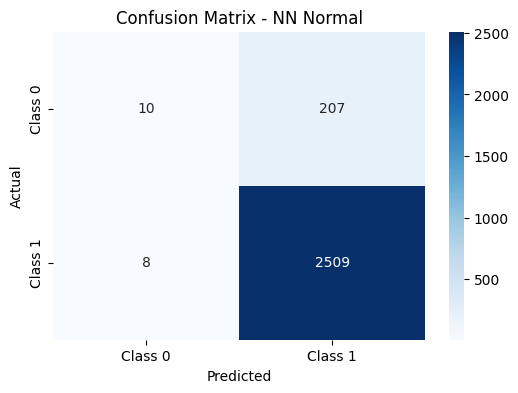

In [15]:


X = past_data.drop(columns="Status")
Y = past_data["Status"]


X_train, X_test, y_train, y_test = train_test_split(
    X, Y, test_size=0.4, random_state=42, stratify=Y
)

nn_normal = keras.Sequential([
     keras.layers.Dense(64, input_shape=(X_train.shape[1],), activation='relu'),
    BatchNormalization(),
    Dropout(0.3),

     keras.layers.Dense(32, activation='relu'),
    BatchNormalization(),
    Dropout(0.2),

     keras.layers.Dense(16, activation='relu'),
     keras.layers.Dense(1, activation='sigmoid')
])
optimizer = Adam(learning_rate=0.001)
loss_fn = BinaryFocalCrossentropy(gamma=2.0)
nn_normal.compile(optimizer="adam", loss=loss_fn, metrics=["accuracy"])

history = nn_normal.fit(
    X_train, y_train,
    epochs=30, batch_size=64,
    validation_split=0.2,
    verbose=1
)

y_pred_probs = nn_normal.predict(X_test).ravel() 
y_pred = (y_pred_probs >= 0.5).astype(int)

cm = confusion_matrix(y_test, y_pred)
acc = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred_probs)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)

print("\nConfusion Matrix:\n", cm)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap="Blues",
            xticklabels=['Class 0', 'Class 1'],
            yticklabels=['Class 0', 'Class 1'])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - NN Normal")
plt.show()




Catboost over sampleing

Before SMOTETomek Resampling: Counter({np.int64(1): 3774, np.int64(0): 326})
After SMOTETomek Resampling: Counter({np.int64(1): 3772, np.int64(0): 3772})
0:	learn: 0.6316383	total: 183ms	remaining: 1m 31s
100:	learn: 0.0413915	total: 3.49s	remaining: 13.8s
200:	learn: 0.0124602	total: 7s	remaining: 10.4s
300:	learn: 0.0059497	total: 10.8s	remaining: 7.14s
400:	learn: 0.0040966	total: 14.3s	remaining: 3.52s
499:	learn: 0.0037847	total: 18.1s	remaining: 0us
Accuracy: 0.9180687637161667
Confusion Matrix:
 [[  29  188]
 [  36 2481]]
ROC AUC Score: 0.6755500385397728


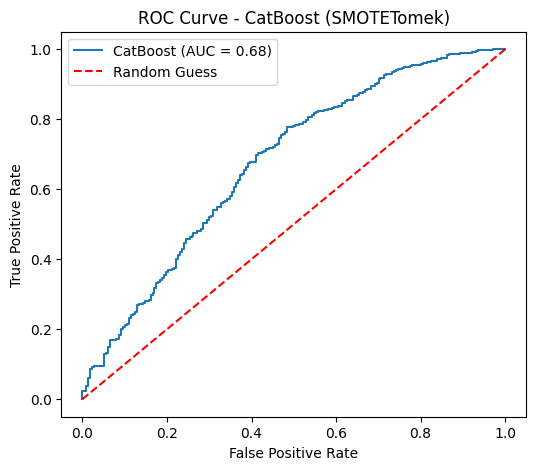

                 Feature  Importance
15                Season   17.619779
10                Decade   13.068878
7                     Hr    7.913091
8                   Mins    6.959052
1                 Rocket    6.435291
14        Launch Country    5.277178
6           pressure_msl    5.269505
5         wind_speed_10m    5.143875
3         temperature_2m    4.788994
9         Year of launch    4.723407
2                Mission    4.701367
4   relative_humidity_2m    4.274889
12       Launch Pad Name    3.935391
13   Launch Pad Location    3.899206
0               Provider    3.721479
11                  AmPm    2.268617


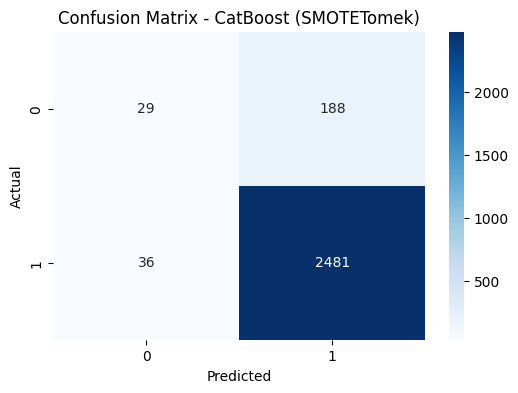

In [16]:

# ---------------- DATA PREPARATION ---------------- #
X = past_data.drop(columns="Status")

# Encode target labels
Y = past_data["Status"].astype("category")
label_encoder = LabelEncoder()
Y_encoded = label_encoder.fit_transform(Y)

# ---------------- TRAIN/TEST SPLIT ---------------- #
X_train, X_test, y_train, y_test = train_test_split(
    X, Y_encoded, test_size=0.4, random_state=42, stratify=Y_encoded
)

# 🔹 PRINT BEFORE RESAMPLING
print("Before SMOTETomek Resampling:", Counter(y_train))

# ---------------- BALANCING WITH SMOTETomek ---------------- #
smote_tomek = SMOTETomek(random_state=42)
X_res, y_res = smote_tomek.fit_resample(X_train, y_train)

# 🔹 PRINT AFTER RESAMPLING
print("After SMOTETomek Resampling:", Counter(y_res))

# ---------------- CATBOOST TRAINING ---------------- #
num_classes = len(label_encoder.classes_)
metric = 'Logloss'

cat_model = CatBoostClassifier(
    iterations=500,
    learning_rate=0.15,
    depth=10,
    eval_metric=metric,
    random_seed=42,
    verbose=100
)

cat_model.fit(X_res, y_res)

# ---------------- PREDICTIONS ---------------- #
y_pred = cat_model.predict(X_test)
y_pred_proba = cat_model.predict_proba(X_test)

# ---------------- EVALUATION ---------------- #
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

# ---------------- ROC CURVE ---------------- #
plt.figure(figsize=(6, 5))
if num_classes == 2:
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba[:, 1])
    roc_auc = auc(fpr, tpr)
    print("ROC AUC Score:", roc_auc)
    plt.plot(fpr, tpr, label=f'CatBoost (AUC = {roc_auc:.2f})')
else:
    y_test_bin = label_binarize(y_test, classes=range(num_classes))
    for i, class_name in enumerate(label_encoder.classes_):
        fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_pred_proba[:, i])
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f'{class_name} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], 'r--', label='Random Guess')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - CatBoost (SMOTETomek)')
plt.legend()
plt.show()

# ---------------- FEATURE IMPORTANCE ---------------- #
importances = cat_model.get_feature_importance()
feature_names = X.columns

feature_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

print(feature_importance_df)

# ---------------- CONFUSION MATRIX HEATMAP ---------------- #
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap="Blues",
            xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - CatBoost (SMOTETomek)")
plt.show()


Random Forest Undersampleing

before Counter({np.int64(1): 5038, np.int64(0): 429})
after Counter({np.int64(0): 429, np.int64(1): 429})
Accuracy: 0.6964155084125823
ROC AUC Score: 0.6548739166351634


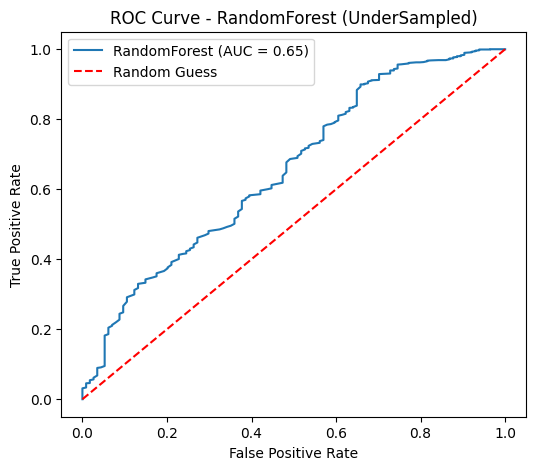

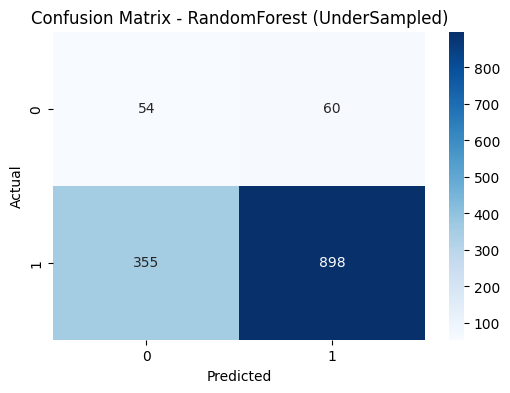

In [23]:

# ---------------- DATA PREP ---------------- #
X = past_data.drop("Status", axis=1)
Y = past_data["Status"].astype("category")

# Encode target labels
label_encoder = LabelEncoder()
Y_encoded = label_encoder.fit_transform(Y)

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, Y_encoded, test_size=0.2, random_state=42
)


# ---------------- BALANCING WITH UNDERSAMPLING ---------------- #
print("before",Counter(y_train))
undersampler = RandomUnderSampler(random_state=42)
X_res, y_res = undersampler.fit_resample(X_train, y_train)
print("after",Counter(y_res))


# ---------------- MODEL TRAINING ---------------- #
random_forest_model = RandomForestClassifier(
    n_estimators=400,
    class_weight="balanced",
    random_state=42
)
random_forest_model.fit(X_res, y_res)

# ---------------- EVALUATION ---------------- #
y_pred = random_forest_model.predict(X_test)
y_pred_proba = random_forest_model.predict_proba(X_test)

accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)
# print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
# print("Classification Report:\n", classification_report(y_test, y_pred, target_names=label_encoder.classes_))

# Save score
Trained_models = {}
Trained_models["RandomForestClassifier"] = accuracy

# ---------------- ROC CURVE ---------------- #
plt.figure(figsize=(6,5))

if len(label_encoder.classes_) == 2:
    # Binary classification ROC
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba[:, 1])
    roc_auc = auc(fpr, tpr)
    print("ROC AUC Score:", roc_auc)
    plt.plot(fpr, tpr, label=f'RandomForest (AUC = {roc_auc:.2f})')
else:
    # Multiclass ROC
    y_test_bin = label_binarize(y_test, classes=range(len(label_encoder.classes_)))
    for i, class_name in enumerate(label_encoder.classes_):
        fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_pred_proba[:, i])
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f'{class_name} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], 'r--', label='Random Guess')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - RandomForest (UnderSampled)')
plt.legend()
plt.show()

# ---------------- FORECASTING ---------------- #
# encoded_forecasting_data = encoder.transform(data_forcasting[categorical_cols])
# y_pred_forecast = model.predict(encoded_forecasting_data)

# # Attach predictions back (decode labels)
# result = data_forcasting.copy()
# result["Predicted_Status"] = label_encoder.inverse_transform(y_pred_forecast)


# ---------------- GRAPHS ---------------- #
# Confusion Matrix Heatmap
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt='d', cmap="Blues",
            xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - RandomForest (UnderSampled)")
plt.show()

# # Actual vs Predicted (scatter plot)
# plt.figure(figsize=(7,4))
# plt.scatter(range(len(y_test)), y_test, label="Actual", alpha=0.7)
# plt.scatter(range(len(y_pred)), y_pred, label="Predicted", alpha=0.7)
# plt.title("Prediction vs Actual - RandomForest (UnderSampled)")
# plt.legend()
# plt.show()

# # Predicted class distribution
# plt.figure(figsize=(6,4))
# sns.countplot(x=label_encoder.inverse_transform(y_pred), palette="Set2")
# plt.title("Predicted Class Distribution - RandomForest (UnderSampled)")
# plt.show()

Real Future Test data

In [24]:
future_data

,Status,Provider,Rocket,Mission,temperature_2m,relative_humidity_2m,wind_speed_10m,pressure_msl,Hr,Mins,Year of launch,Decade,AmPm,Launch Pad Name,Launch Pad Location,Launch Country,Season
6834,2,-0.469862,0.727515,-1.636707,0.788492,0.280070,-0.410324,-0.014710,1.175469,-1.45836,1.698752,1.629507,1.172456,0.543995,-1.357368,1.088903,-1.332336
6836,2,-1.336407,-0.655023,-1.112652,1.455486,-0.596590,-0.045444,-1.420688,1.027638,-1.45836,1.952135,2.124760,1.172456,1.089126,0.630402,-1.735066,1.359229
6837,2,0.239130,0.660308,-0.623280,1.434013,0.471302,0.868514,-0.890264,1.027638,-1.45836,1.952135,2.124760,1.172456,-0.300080,1.624287,0.080343,1.359229
6838,2,-0.469862,0.727515,-1.636165,1.080529,0.552952,-0.595224,0.014050,0.436315,-1.45836,1.901458,1.629507,1.172456,0.543995,-0.057672,1.088903,-1.332336
6835,2,0.633014,-0.933450,-1.522900,-1.937961,0.888145,-0.732318,-0.548906,0.436315,-1.45836,1.952135,2.124760,1.172456,1.229805,-0.898652,1.088903,-0.435147


In [25]:
X_future = future_data.drop("Status", axis=1)

In [41]:
nn_normal.predict(X_future).flatten()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


array([0.73898137, 0.53325754, 0.6657809 , 0.7373512 , 0.69622463],
      dtype=float32)

NN Model Predictions

In [39]:
probs = nn_normal.predict(X_future).flatten()
predicted_values = (probs >= 0.5).astype(int)

print(predicted_values)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
[1 1 1 1 1]


Catboost Model Predictions

In [27]:
cat_model.predict(X_future)

array([1, 1, 1, 1, 1])

Random Forest Model Prediction

In [28]:
random_forest_model.predict(X_future)

array([1, 1, 1, 0, 1])

In [47]:
data_dict = {
    "Provider": [
        "NASA",
        "SpaceX",
        "ISRO",
        "ROSCOSMOS",
        "NASA"
    ],
    "Mission": [
        "Artemis II",
        "Crew-13",
        "Gaganyaan-1",
        "Luna 26",
        "Artemis V"
    ],
    "Rocket": [
        "Space Launch System (SLS)",
        "Falcon 9",
        "LVM-3 (GSLV Mk III)",
        "Soyuz 2.1b/Fregat-M",
        "Space Launch System (SLS)"
    ],
    "Temperature": [22.53333333, -11.85416667, 30.94583333, 30.675, 26.21666667],
    "Humidity": [74.20833333, 86, 57.20833333, 77.91666667, 79.5],
    "Wind Speed": [11.64583333, 9.7375, 13.80833333, 19.225, 10.55],
    "Pressure": [1015.370833, 1010.65, 1002.945833, 1007.633333, 1015.625],
    "Launch Date": [
        "29-09-2025",
        "30-03-2030",
        "30-12-2025",
        "30-12-2027",
        "29-09-2029"
    ]
}

df = pd.DataFrame(data_dict)

# Add predictions to table
df["NN Normal"] = predicted_values
df["Catboost Oversampled"] = cat_model.predict(X_future)
df["Random Forest Undersampled"] = random_forest_model.predict(X_future)

# Print as table
print(df.to_string(index=False))

 Provider     Mission                    Rocket  Temperature  Humidity  Wind Speed    Pressure Launch Date  NN Normal  Catboost Oversampled  Random Forest Undersampled
     NASA  Artemis II Space Launch System (SLS)    22.533333 74.208333   11.645833 1015.370833  29-09-2025          0                     1                           1
   SpaceX     Crew-13                  Falcon 9   -11.854167 86.000000    9.737500 1010.650000  30-03-2030          1                     1                           1
     ISRO Gaganyaan-1       LVM-3 (GSLV Mk III)    30.945833 57.208333   13.808333 1002.945833  30-12-2025          0                     1                           1
ROSCOSMOS     Luna 26       Soyuz 2.1b/Fregat-M    30.675000 77.916667   19.225000 1007.633333  30-12-2027          1                     1                           0
     NASA   Artemis V Space Launch System (SLS)    26.216667 79.500000   10.550000 1015.625000  29-09-2029          0                     1                     